# Probabilistic ML

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from sklearn.linear_model import LogisticRegression as lr
from sklearn.svm import LinearSVC as csvm
from matplotlib import pyplot as plt

**Generating Toy Data**: let us use our pair of obliquely placed ellipsoids to understand how probabilistic methods can help us evaluate ML models better

(-10, 10)

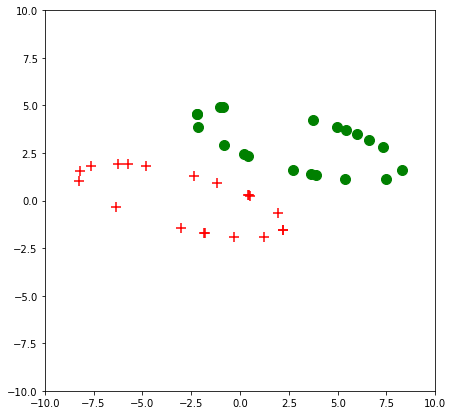

In [3]:
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

d = 2 
n = 20

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )

yPos = np.ones( (n,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig = pd.getFigure( 7, 7 )
pd.plot2D( XPos, fig, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig, color = 'g', marker = 'o' )
plt.xlim( -10, 10 )
plt.ylim( -10, 10 )

**Logistic Regression**: let us perform logistic regression on this data. We will notice that logistic regression does not necessarily maximize margin (which the CSVM does). The shading in this figure is probabilistic and encodes the PMF the logistic model assigns to a data point
1. A dark shade of any color (red/green) corresponds to a confident prediction of that label
1. A light shade of any color (red/green) corresponds to a less confident prediction of that label
1. A very light (almost white) shade corresponds to an almost confused prediction indicating that the point may be close to the decision boundary.

Note that close to the decision boundary, logistic regression gives confused PMFs (the shading color is almost white). Far away from the decision boundary, logistic regression gives a confident answer (the color is either dark red or dark green). The actual decision boundary of the classifier is also indicated as a dotted black line.

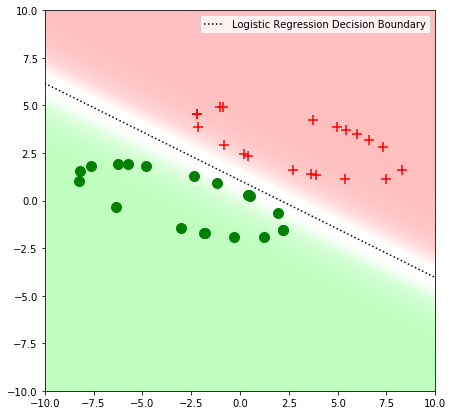

In [4]:
clf = lr( penalty= "l2", C = 1.0, fit_intercept = True, solver = "liblinear" )
clf.fit( X, y )

# The predict_proba routine returns the entire PMF. We only need P[y = 1] to perform shading
def logRegBatch( X ):
    return clf.predict_proba( X )[:,1]

fig2 = pd.getFigure( 7, 7 )
pd.shade2DProb( logRegBatch, fig2, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'g', marker = 'o' )
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig2, linestyle = ':', label = "Logistic Regression Decision Boundary" )

**Obtaining Confidence Scores from Non-probabilistic Models**: we may execute the CSVM classifier on the same data to obtain a model. This model is expected to offer us a better margin but in itself, the CSVM model does not offer probabilistic predictions i.e. it does not output a PMF over labels). However, it is often possible to extract confidence scores from such non-probabilistic models such as the CSVM model by using a simple sigmoidal map.

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


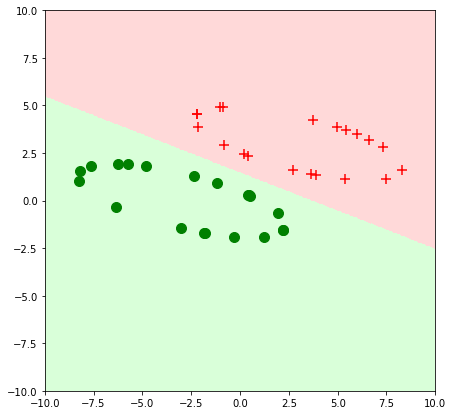

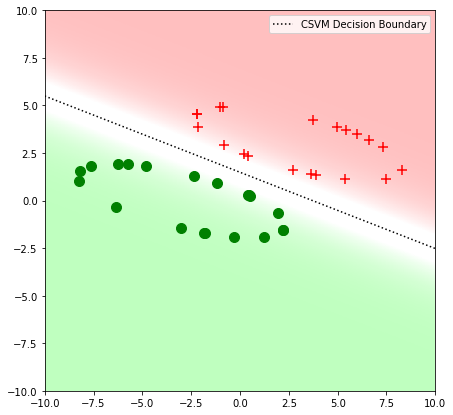

In [5]:
clf2 = csvm( penalty= "l2", loss = "hinge", C = 1.0, fit_intercept = True )
clf2.fit( X, y )

# By itself, the CSVM offers a hard label i.e. either -1 or +1
# We could have just returned clf2.predict( X ) too
def CSVM( X ):
    return np.sign( X.dot(clf2.coef_.T) + clf2.intercept_ )

fig3 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig3, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = 'o' )
pd.plot2D( XNeg, fig3, color = 'r', marker = '+' )

# Use the sigmoidal map to extract a PMF from the CSVM model
def CSVMProb( X ):
    w = clf2.coef_.T
    b = clf2.intercept_
    score = X.dot(w) + b
    return 1/(1 + np.exp(-score))

fig4 = pd.getFigure( 7, 7 )
pd.shade2DProb( CSVMProb, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'g', marker = 'o' )
pd.plot2D( XNeg, fig4, color = 'r', marker = '+' )
pd.plotLine( clf2.coef_.T, clf2.intercept_, fig4, linestyle = ':', label = "CSVM Decision Boundary" )

**Benefits of Probabilistic Predictions**: if our data is badly mixed up and not linearly separable, then probabilistic methods may become very useful in warning us that the ML model is struggling or confused on the data which then allows us to take corrective steps such as choosing a more powerful model, increase the amount of training data etc.

For example, in the following toy dataset, the data points are not linearly separable. Logistic regression gives us a PMF which we can use to gauge the confidence of the model on a data point. If the confidence of the model is low on several/most data points, we may ask some other model/even a human to classify that data point. Indeed, notice that in the example below, even several training points are lying in low-confidence regions where the color is almost white. This is an indication that a linear model may not be suitable to classify this data.

Non-probabilistic models like CSVM, on the other hand, simply output labels themselves which do not tell us crisply whether a data point is dangerously close to decision boundary or not. However, it should be noted that often, it is possible to extract a probabilistic classification out of a non-probabilistic model like CSVM (as we did above using the sigmoidal map).

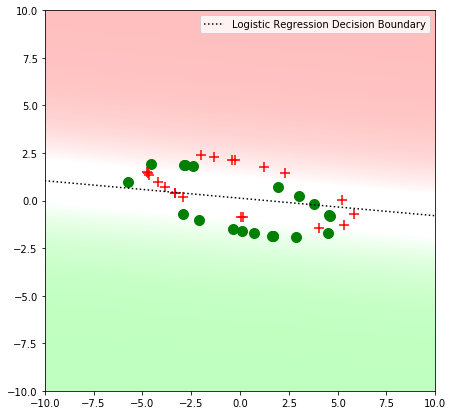

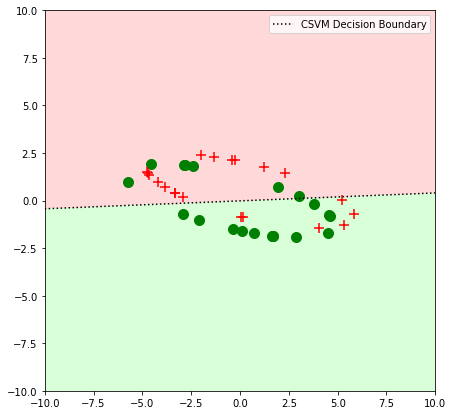

In [6]:
muPos = np.array( [-0.5,0] )
muNeg = np.array( [0.5,0.5] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )

yPos = np.ones( (n,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

clf.fit( X, y )
clf2.fit( X, y )

fig5 = pd.getFigure( 7, 7 )
pd.shade2DProb( logRegBatch, fig5, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig5, color = 'g', marker = 'o' )
pd.plot2D( XNeg, fig5, color = 'r', marker = '+' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig5, linestyle = ':', label = "Logistic Regression Decision Boundary" )

fig6 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig6, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig6, color = 'g', marker = 'o' )
pd.plot2D( XNeg, fig6, color = 'r', marker = '+' )
pd.plotLine( clf2.coef_.T, clf2.intercept_, fig6, linestyle = ':', label = "CSVM Decision Boundary" )